In [21]:
# Release memory
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [22]:
%matplotlib inline

import os
import gc
import time
import random
import multiprocessing as mp

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation, cm, ticker
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from IPython.display import HTML

from scipy import signal, ndimage
from scipy.optimize import minimize

from google.colab import files

### Computational Domain


In [23]:
scale = 101

nx = scale
nz = scale
nt = 750

dx = 10.0
dz = 10.0
dt = 1e-3

xmin = 0
xmax = nx * dx # (m)
zmin = 0
zmax = nz * dz # (m)
tmin = 0
tmax = nt * dt # (s)

print((xmax, zmax, tmax))

# mesh
x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
X, Z = np.meshgrid(x, z, indexing='ij')

(1010.0, 1010.0, 0.75)


### Finite Difference Wave Solvers

In [24]:
def dfdx(fx, dx):
    dfdx, _ = np.gradient(fx, dx, dz)
    return dfdx

def dfdz(fz, dz):
    _, dfdz = np.gradient(fz, dx, dz)
    return dfdz
  
def divergence(fx, fz, dx, dz):
    dfdx, _ = np.gradient(fx, dx, dz)
    _, dfdz = np.gradient(fz, dx, dz)
    return dfdx + dfdz
  
def laplacian(f, dx, dz):
    dfdx, dfdz = np.gradient(f, dx, dz)
    d2fdx2, d2fdxdz = np.gradient(dfdx, dx, dz)
    d2fdzdx, d2fdz2 = np.gradient(dfdz, dx, dz)
    return d2fdx2 + d2fdz2

def d2dt2(f, dt):
    dfdt, _, _ = np.gradient(f, dt, dt, dt)
    d2fdt2, _, _ = np.gradient(dfdt, dt, dt, dt)
    return d2fdt2

def dfdt(f, dt):
    dfdt, _, _ = np.gradient(f, dt, dt, dt)
    return dfdt

def timer(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [25]:
def wave_solver(c, dt, dx, dz, nt, nx, nz, f, sigma_1, sigma_2):

    u = np.zeros((nt,nx,nz))
    u_xx = np.zeros((nx,nz))
    u_zz = np.zeros((nx,nz))
    q_1 = np.zeros((nx,nz))
    q_2 = np.zeros((nx,nz))

    C1 = 1 + dt*(sigma_1 + sigma_2)/2
    C2 = sigma_1 * sigma_2 * (dt**2) - 2
    C3 = 1 - dt*(sigma_1 + sigma_2)/2
    C4 = (dt*c)**2
    C5 = 1 + dt*sigma_1/2
    C6 = 1 + dt*sigma_2/2
    C7 = 1 - dt*sigma_1/2
    C8 = 1 - dt*sigma_2/2

    for n in range(1, nt-1):
        u_xx[1:-1, 1:-1] = u[n,:-2,1:-1] - 2*u[n,1:-1,1:-1] + u[n,2:,1:-1]
        u_zz[1:-1, 1:-1] = u[n,1:-1,:-2] - 2*u[n,1:-1,1:-1] + u[n,1:-1,2:]

        u[n+1] = (C4*(u_xx/(dx**2) + u_zz/(dz**2) - divergence(q_1*sigma_1, q_2*sigma_2, dx, dz)+ sigma_2*dfdx(q_1, dx) + sigma_1*dfdz(q_2, dz) + f[n]) - \
          C2 * u[n] - C3 * u[n-1]) / C1

        q_1 = (dt*dfdx(u[n], dx) + C7*q_1) / C5
        q_2 = (dt*dfdz(u[n], dx) + C8*q_2) / C6

        # Enforce Dirichlet boundary condition
        u[n+1, :, 0] = np.zeros(nx)
        u[n+1, :, nz-1] = np.zeros(nx)
        u[n+1, 0, :] = np.zeros(nz)
        u[n+1, nx-1, :] = np.zeros(nz)

    return u

### Velocity Profile

In [26]:
def plot_profile(c, scale=1, num_level=10, title=None, cmap=None, save=False, name="no_name"):
    x_k = np.linspace(xmin / 1000, xmax / 1000, nx)
    z_k = np.linspace(zmin / 1000, zmax / 1000, nz)
    X_k, Z_k = np.meshgrid(x_k, z_k, indexing='ij')

    vmin = np.min(c) / scale
    vmax = np.max(c) / scale
    levels = np.linspace(vmin, vmax, num_level)

    figure(figsize=(5, 4), dpi=70)
    plt.subplot()
    plt.xlabel("x (km)")
    plt.ylabel("z (km)")
    con = plt.contourf(X_k, Z_k, c, levels=levels, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.title(title)
    plt.colorbar()

    plt.gca().invert_yaxis()

    plt.tight_layout();

    if (save == True):
      plt.savefig(name + '.png')
      files.download(name + '.png');

(505.0, 505.0)


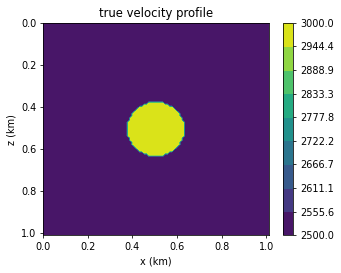

In [27]:
c_true_1 = 2500*np.ones((nx,nz))

x_0 = xmax / 2
z_0 = zmax // 2 
r = 8e3

for i in range(nx):
    for j in range(nz):
        if ((X[i,j]-x_0)**2 + (Z[i,j]-z_0)**2 <= r*2):
            c_true_1[i,j] += 500

print((x_0, z_0))

plot_profile(c_true_1, title="true velocity profile")

### Attenuation Coefficients

In [28]:
def get_sigma_1(x, dx, c_max, n=10, R=1e-3, m=2):

    """
    parameters:
        x: 1d array
        dx: float (step size)
        c_max: float (maximum velocity in the profile) m/s
        n: int (number of grid; see below)
        R: float (the multiplicative factor for attenuation)
        m: int (order of poloynomial; the larger the m, the faster sigma grows)
    return:
        sigma_1: 2d array
    """

    # n is the width of PML in terms of the number of grid points
    PMLwidth = n * dx
    # see derivation in my note
    sigma_max = - c_max * np.log(R) * (m+1) / (PMLwidth**(m+1))
    # the value of the interface point
    x_0 = np.max(x) - PMLwidth
    sigma_1 = np.zeros((nx,nz))
    # First take care of the layer on the right
    # If the value is greater than x_0, we record its index
    idx = [i for i,v in enumerate(x) if np.abs(v) > x_0]
    # This should return a 2d array, in which each column (axis=1)
    # looks like [-3, -2, -1, 0, ..., 0, 1, 2 ,3 ]
    for i in idx:
        sigma_1[i] = sigma_max * np.abs(x[i] - x_0)**m
    sigma_1 = sigma_1 + np.flipud(sigma_1)
    
    return sigma_1



def get_sigma_2(z, dz, c_max, n=30, R=1e-3, m=2):
  
    PMLwidth = n * dz
    sigma_max = - c_max * np.log(R) * (m+1) / (PMLwidth**(m+1))
    z_0 = np.max(z) - PMLwidth
    sigma_2 = np.zeros((nx,nz))
    idz = [i for i,v in enumerate(z) if np.abs(v) > z_0]
    for i in idz:
        sigma_2[:,i] = sigma_max * np.abs(z[i] - z_0)**m
    sigma_2 = sigma_2 + np.fliplr(sigma_2)

    return sigma_2

In [29]:
sigma_1 = get_sigma_1(x=x, dx=dx, c_max=3000, n=10, R=1e-3, m=2)
sigma_2 = get_sigma_2(z=z, dz=dz, c_max=3000, n=10, R=1e-3, m=2)

### Source

In [30]:
def ricker(i_s, j_s, f=10, amp=1e0, shift=0.1, extra=False):
    """
    creates a source function (ricker pulse signal)
    f(t,x,y) = g(t) delta(x-x_s) delta(y-y_s)

    parameters:
    x_s, y_s: indices of location of the signal
    f: peak frequency
    amplitude: the default is 1
    shift: shifts the center to left or right

    return:
    3d array (discretized f(t,x,y))
    """

    t = np.linspace(tmin, tmax, nt)
    pft2 = (np.pi * f * (t - shift))**2
    r = amp * (1 - 2 * pft2) * np.exp(-pft2)

    if (extra == True):
      pft2 = (np.pi * f_M * (t - 2 * shift))**2
      r += 0.1 * amp * (1 - 2 * pft2) * np.exp(-pft2)

    x = np.zeros(nx)
    z = np.zeros(nz)
    x[i_s] = 1.0
    z[j_s] = 1.0
    R, X, Z = np.meshgrid(r, x, z, sparse=True, indexing='ij')

    return R*X*Z

In [31]:
%%time

width = 10

# Number of sources
N_S = 5
f_s = np.empty((N_S, nt, nx, nz))

# we will put the sources on the same z-level
srs_pos = int(2 * width)

# Peak Frequency
f_M = 10

# Shift to right
shift = 0.1

# Amplitude
amp = 1e0

# We put N_S sources along the x-axis
loc = np.linspace(start=width+2, stop=nz-width-2, num=N_S, dtype=np.int32)

# We store the location of these sources
pos_s = np.empty((N_S, 2), dtype=np.int32)


for s in range(N_S):
    f_s[s] = ricker(i_s=srs_pos, j_s=loc[s], f=f_M, amp=1e0, shift=shift, extra=False)
    # Keep track of source locations
    pos_s[s] = np.array([srs_pos, loc[s]])

CPU times: user 127 ms, sys: 911 µs, total: 128 ms
Wall time: 127 ms


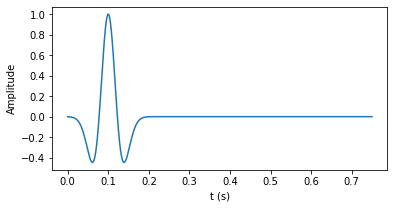

In [32]:
t = np.linspace(tmin, tmax, nt)
pft2 = (np.pi * f_M * (t - shift))**2
r = amp * (1 - 2 * pft2) * np.exp(-pft2)
  
plt.subplots(figsize=(6, 3))
plt.plot(t, r)
plt.xlabel('t (s)')
plt.ylabel('Amplitude');


In [33]:
%%time

u_1 = wave_solver(c_true_1, dt, dx, dz, nt, nx, nz, f_s[0], sigma_1, sigma_2)


CPU times: user 714 ms, sys: 4.58 ms, total: 718 ms
Wall time: 713 ms


In [34]:
def make_cartoon(u, vmin, vmax, num_level=100, skip=10, size=5, interval=80, cmap=None):
    x = np.linspace(xmin, xmax, nx)
    z = np.linspace(zmin, zmax, nz)
    X, Z = np.meshgrid(x, z, indexing='ij')
    levels = np.linspace(vmin, vmax, num_level)

    fig, ax = plt.subplots(figsize=(size, size))
    ax.contourf(X, Z, u[0], levels=levels, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_ylabel("z (m)")

    plt.gca().set_aspect('equal', adjustable='box')
    
    def animate(i):
        i *= skip
        ax.clear()
        ax.text(0.45, 1.05, "t = {0:0.2f}".format(np.round(i*dt, 2)), transform=ax.transAxes)
        ax.contourf(X, Z, u[i], levels=levels, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.invert_yaxis()
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")

        plt.close()

    return animation.FuncAnimation(fig, animate, interval=interval, frames=int(len(u)/skip))
  

In [35]:
anim = make_cartoon(u_1, vmin=np.min(u_1)/5.0, vmax=np.max(u_1)/5.0, skip=10)
HTML(anim.to_jshtml())